In [1]:
import matplotlib.pyplot as plt
import numpy as np
import chipwhisperer as cw

target = cw.target(None, cw.targets.CW305, force=True, bsfile="/home/boochoo/project/CW305_power_analysis/vivado_power/vivado_power.runs/impl_1/cw305_top.bit")

(ChipWhisperer Target WARNING|File CW305.py:591) Using default Verilog defines (/home/boochoo/chipwhisperer/software/chipwhisperer/hardware/firmware/cw305/cw305_aes_defines.v); if this is not what you want, provide them via the defines_files argument


In [2]:
hz = 50E5

ps3000a_range = ["PS3000A_10MV",
    "PS3000A_20MV",
    "PS3000A_50MV",
    "PS3000A_100MV",
    "PS3000A_200MV",
    "PS3000A_500MV",
    "PS3000A_1V",
    "PS3000A_2V",
    "PS3000A_5V",
    "PS3000A_10V",
    "PS3000A_20V",
    "PS3000A_50V",
    "PS3000A_MAX_RANGES",]

target.vccint_set(1.0)

target.pll.pll_enable_set(True)
target.pll.pll_outenable_set(False, 0)
target.pll.pll_outenable_set(True, 1)
target.pll.pll_outenable_set(False, 2)

target.pll.pll_outfreq_set(hz, 1)

In [3]:
def read_y_128_mem_as_int_list(filename):
    """ 
    y_128.mem 파일을 읽고 각 줄을 2진수에서 정수로 변환하여 리스트로 반환 
    """
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # 2진수를 정수(int)로 변환하여 리스트에 저장
    int_list = [int(line.strip(), 2) for line in lines]
    
    return int_list

def number_to_bytearray(num, high_bits=0, size=16):
    """ 
    숫자를 지정된 바이트 크기로 변환하는 함수.
    high_bits (0~3): 최상위 2비트 (128, 127 비트)를 설정할 값
    """
    if not (0 <= high_bits <= 3):
        raise ValueError("high_bits는 0~3 사이의 값이어야 합니다.")

    # 126비트 값만 유지하고, 최상위 2비트는 high_bits로 변경
    num = (num & ((1 << 126) - 1)) | (high_bits << 126)

    return num.to_bytes(size, byteorder='little')

def read_key(index):
    target.fpga_write(target.REG_CRYPT_TEXTIN, bytearray(16))
    target.fpga_write(target.REG_CRYPT_KEY, number_to_bytearray(index, 0))
    target.go()
    result_byte = target.fpga_read(target.REG_CRYPT_CIPHEROUT, 16)
    return int.from_bytes(result_byte, byteorder='little')

def write_key_txt(key_value, plain_values):
    for i in range(len(key_value) + len(plain_values)):
        target.fpga_write(target.REG_CRYPT_KEY, number_to_bytearray(i,0))
        if i < len(key_value):
            target.fpga_write(target.REG_CRYPT_TEXTIN, key_value[i].to_bytes(16, byteorder='little'))
        else:
            target.fpga_write(target.REG_CRYPT_TEXTIN, plain_values[i-len(key_value)].to_bytes(16, byteorder='little'))
        target.go()

def key_verify(key_value):
    err = []
    for i in range(len(key_value)):
        # print(read_key(i))
        if read_key(i) != key_value[i]:
            err.append(i)
    return err

def plain_verify(key_value, plain_value):
    err = []
    key_len = len(key_value)
    for i in range(len(plain_value)):
        # print(read_key(key_len + i))
        if read_key(key_len + i) != plain_value[i]:
            err.append(i)
    return err

def capture_trace(target, plain_text, key):
    target.simpleserial_write('k', key)
    target.simpleserial_write('p', plain_text)
    target.go()

def filtering(channelA_trace, channelB_trace):
    count = 0
    index = 0
    trace = []
    for i in range(len(channelA_trace)):
        if channelB_trace[i] > 100:
            trace.append(channelA_trace[i])
    return trace
    

In [4]:
#picoscope setting
from picosdk.ps3000a import ps3000a as ps
from picosdk.functions import adc2mV, mV2adc, assert_pico_ok
import ctypes
# Create chandle and status ready for use

def picoscope_setting():
    status = {}
    chandle = ctypes.c_int16()

    # Opens the device/s
    status["openunit"] = ps.ps3000aOpenUnit(ctypes.byref(chandle), None)

    try:
        assert_pico_ok(status["openunit"])
    except:

        # powerstate becomes the status number of openunit
        powerstate = status["openunit"]

        # If powerstate is the same as 282 then it will run this if statement
        if powerstate == 282:
            # Changes the power input to "PICO_POWER_SUPPLY_NOT_CONNECTED"
            status["ChangePowerSource"] = ps.ps3000aChangePowerSource(chandle, 282)
            # If the powerstate is the same as 286 then it will run this if statement
        elif powerstate == 286:
            # Changes the power input to "PICO_USB3_0_DEVICE_NON_USB3_0_PORT"
            status["ChangePowerSource"] = ps.ps3000aChangePowerSource(chandle, 286)
        else:
            raise

        assert_pico_ok(status["ChangePowerSource"])

    # 채널 설정
    chARange = 1  # ±5V 범위, AC Coupling
    status = {}
    status["setChA"] = ps.ps3000aSetChannel(chandle, 0, 1, 0, chARange, 0)  # 채널 A 활성화, AC Coupling
    assert_pico_ok(status["setChA"])

    chBRange = 8  # ±2V 범위 (PS3000A_2V), DC Coupling
    status["setChB"] = ps.ps3000aSetChannel(chandle, 1, 1, 1, chBRange, 0)  # 채널 B 활성화, DC Coupling
    assert_pico_ok(status["setChB"])

    # 채널 C 비활성화
    status["setChC"] = ps.ps3000aSetChannel(chandle, 2, 0, 0, 0, 0)  # enabled=0
    assert_pico_ok(status["setChC"])

    # 채널 D 비활성화
    status["setChD"] = ps.ps3000aSetChannel(chandle, 3, 0, 0, 0, 0)  # enabled=0
    assert_pico_ok(status["setChD"])

    status["trigger"] = ps.ps3000aSetSimpleTrigger(chandle, 1, 1, 512, 3, 0, 5000) 
    assert_pico_ok(status["trigger"])

    # 샘플 개수 설정
    preTriggerSamples = 200000
    postTriggerSamples = 500000
    maxsamples = preTriggerSamples + postTriggerSamples

    # 타임베이스 정보 얻기
    timebase = 1 #1
    timeIntervalns = ctypes.c_float()
    returnedMaxSamples = ctypes.c_int16()
    status["GetTimebase"] = ps.ps3000aGetTimebase2(chandle, timebase, maxsamples, ctypes.byref(timeIntervalns), 1, ctypes.byref(returnedMaxSamples), 0) #4ns per one sample
    assert_pico_ok(status["GetTimebase"])

    # 오버플로우 변수
    overflow = ctypes.c_int16()

    return chandle, preTriggerSamples, postTriggerSamples, timebase, status, maxsamples, overflow, chARange, chBRange



In [32]:
plain_values = []
plain_values.append(read_y_128_mem_as_int_list("/home/boochoo/project/CW305_power_analysis/jupyter/pattern_0.mem"))
plain_values.append(read_y_128_mem_as_int_list("/home/boochoo/project/CW305_power_analysis/jupyter/pattern_8.mem"))
plain_values.append(read_y_128_mem_as_int_list("/home/boochoo/project/CW305_power_analysis/jupyter/pattern_16.mem"))
plain_values.append(read_y_128_mem_as_int_list("/home/boochoo/project/CW305_power_analysis/jupyter/pattern_24.mem"))

In [33]:
print("plain_values", plain_values)
print("len(plain_values)", len(plain_values))

plain_values [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 240, 3840, 61440, 3840, 240, 15, 2

In [34]:
def trans(plain_values):
    n = plain_values
    b = n.to_bytes(16, 'little')

    # 상위 바이트 (오른쪽) FF로 덮기
    b = b[:1] + b[1:15] + b'\xFF'  # 마지막 바이트만 FF
    return b

trans(plain_values[0][1])

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff'

In [39]:
from tqdm.notebook import tnrange


channelA_trace = []

traces = []
N = 40
for j in range(len(plain_values)):

    for i in range(len(plain_values[j])):
        target.fpga_write(target.REG_CRYPT_TEXTIN, trans(plain_values[j][i]))
        target.fpga_write(target.REG_CRYPT_KEY, number_to_bytearray(i,0))
        target.go()
        
        answer = target.fpga_read(target.REG_CRYPT_CIPHEROUT, 16)
        print(int.from_bytes(answer, byteorder='little'))

    bufA = []

    for i in tnrange(N, desc='Capturing traces'):

        chandle, preTriggerSamples, postTriggerSamples, timebase, status, maxsamples, overflow, chARange, chBRange = picoscope_setting()


        target.fpga_write(target.REG_CRYPT_TEXTIN, bytearray([0x00] * 16))
        target.fpga_write(target.REG_CRYPT_KEY, number_to_bytearray(7000, 0))

        status["runblock"] = ps.ps3000aRunBlock(chandle, preTriggerSamples, postTriggerSamples, timebase, 1, None, 0, None, None)
        assert_pico_ok(status["runblock"])
        
        target.go()
        
            
        # 블록 캡처에 사용할 데이터 버퍼 생성
        # 채널 A용 버퍼 (Max 및 Min 버퍼; 여기서는 downsampling 용 최소 버퍼는 사용하지 않습니다.)
        bufferAMax = (ctypes.c_int16 * maxsamples)()
        bufferAMin = (ctypes.c_int16 * maxsamples)()

        # 채널 B용 버퍼 생성
        bufferBMax = (ctypes.c_int16 * maxsamples)()
        bufferBMin = (ctypes.c_int16 * maxsamples)()

        # 데이터 버퍼 설정: 채널 A
        status["SetDataBuffersA"] = ps.ps3000aSetDataBuffers(chandle, 0, bufferAMax, bufferAMin, maxsamples, 0, 0)
        assert_pico_ok(status["SetDataBuffersA"])

        # 데이터 버퍼 설정: 채널 B
        status["SetDataBuffersB"] = ps.ps3000aSetDataBuffers(chandle, 1, bufferBMax, bufferBMin, maxsamples, 0, 0)
        assert_pico_ok(status["SetDataBuffersB"])

        # 데이터 수집 완료 대기
        ready = ctypes.c_int16(0)
        check = ctypes.c_int16(0)
        while ready.value == check.value:
            status["isReady"] = ps.ps3000aIsReady(chandle, ctypes.byref(ready))

        # 수집된 데이터 읽기
        cmaxSamples = ctypes.c_int32(maxsamples)
        status["GetValues"] = ps.ps3000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
        assert_pico_ok(status["GetValues"])

        # 최대 ADC 값 조회
        maxADC = ctypes.c_int16()
        status["maximumValue"] = ps.ps3000aMaximumValue(chandle, ctypes.byref(maxADC))
        assert_pico_ok(status["maximumValue"])

        # 채널 A와 채널 B의 ADC 데이터를 mV로 변환
        adc2mVChAMax = adc2mV(bufferAMax, chARange, maxADC)
        adc2mVChBMax = adc2mV(bufferBMax, chBRange, maxADC)

        traces.append(adc2mVChAMax)
        
        # 블록 캡처에 사용할 데이터 버퍼 생성
        # 채널 A용 버퍼 (Max 및 Min 버퍼; 여기서는 downsampling 용 최소 버퍼는 사용하지 않습니다.)
        bufferAMax = (ctypes.c_int16 * maxsamples)()
        bufferAMin = (ctypes.c_int16 * maxsamples)()

        # 채널 B용 버퍼 생성
        bufferBMax = (ctypes.c_int16 * maxsamples)()
        bufferBMin = (ctypes.c_int16 * maxsamples)()

        # 데이터 버퍼 설정: 채널 A
        status["SetDataBuffersA"] = ps.ps3000aSetDataBuffers(chandle, 0, bufferAMax, bufferAMin, maxsamples, 0, 0)
        assert_pico_ok(status["SetDataBuffersA"])

        # 데이터 버퍼 설정: 채널 B
        status["SetDataBuffersB"] = ps.ps3000aSetDataBuffers(chandle, 1, bufferBMax, bufferBMin, maxsamples, 0, 0)
        assert_pico_ok(status["SetDataBuffersB"])

        # 데이터 수집 완료 대기
        ready = ctypes.c_int16(0)
        check = ctypes.c_int16(0)
        while ready.value == check.value:
            status["isReady"] = ps.ps3000aIsReady(chandle, ctypes.byref(ready))

        # 수집된 데이터 읽기
        cmaxSamples = ctypes.c_int32(maxsamples)
        status["GetValues"] = ps.ps3000aGetValues(chandle, 0, ctypes.byref(cmaxSamples), 0, 0, 0, ctypes.byref(overflow))
        assert_pico_ok(status["GetValues"])

        # 최대 ADC 값 조회
        maxADC = ctypes.c_int16()
        status["maximumValue"] = ps.ps3000aMaximumValue(chandle, ctypes.byref(maxADC))
        assert_pico_ok(status["maximumValue"])

        # 채널 A와 채널 B의 ADC 데이터를 mV로 변환
        adc2mVChAMax = adc2mV(bufferAMax, chARange, maxADC)
        adc2mVChBMax = adc2mV(bufferBMax, chBRange, maxADC)

        bufA.append(filtering(adc2mVChAMax, adc2mVChBMax))
        
        status["stop"] = ps.ps3000aStop(chandle)
        assert_pico_ok(status["stop"])
        status["close"] = ps.ps3000aCloseUnit(chandle)
        assert_pico_ok(status["close"])
    
    channelA_trace.append(bufA)


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Capturing traces:   0%|          | 0/40 [00:00<?, ?it/s]

15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240
3840
61440
3840
240
15
240


Capturing traces:   0%|          | 0/40 [00:00<?, ?it/s]

255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280
255
65280


Capturing traces:   0%|          | 0/40 [00:00<?, ?it/s]

16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280
16711935
65280


Capturing traces:   0%|          | 0/40 [00:00<?, ?it/s]

In [40]:
print(len(channelA_trace[0][0]))

13036


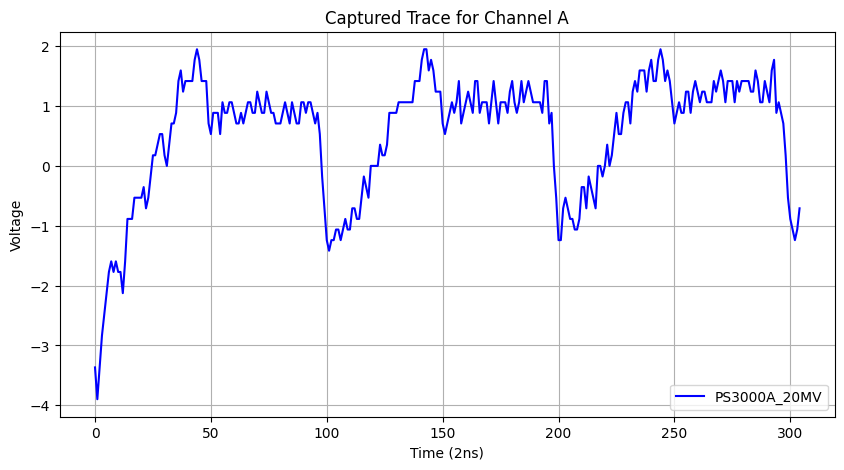

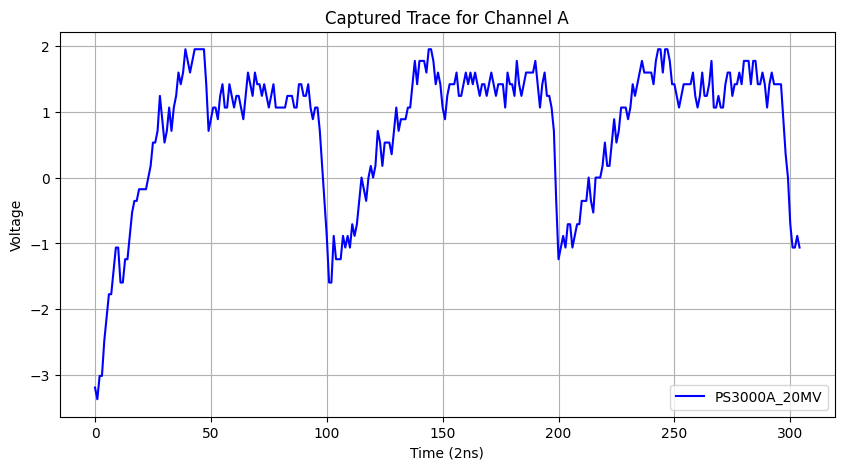

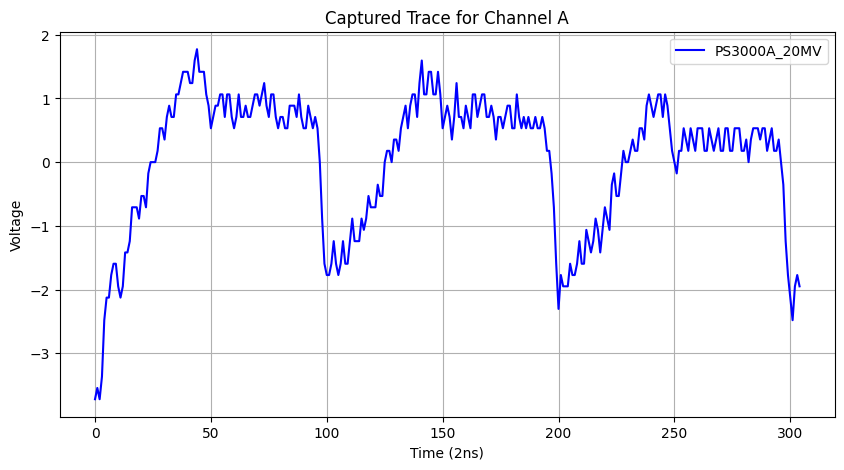

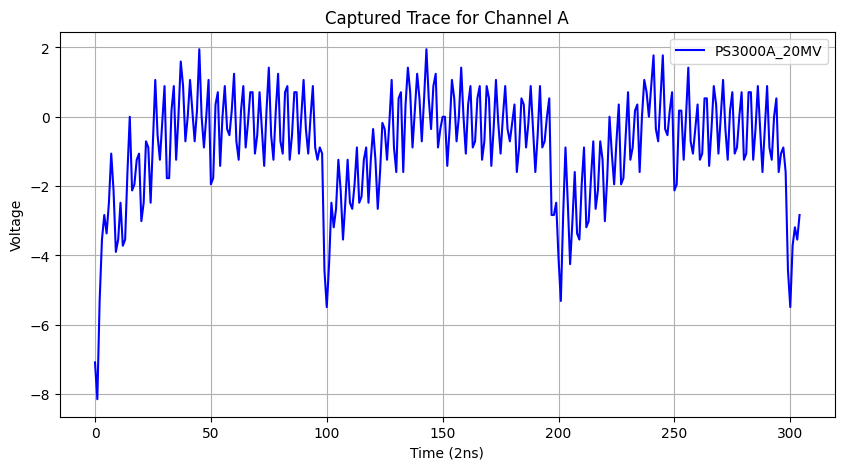

In [41]:



# 채널 A 그래프
plt.figure(figsize=(10, 5))
plt.plot(channelA_trace[0][0][0:305], label=f"{ps3000a_range[chARange]}", color='blue')
plt.xlabel("Time (2ns)")
plt.ylabel("Voltage")
plt.title("Captured Trace for Channel A")
plt.legend()
plt.grid()
plt.show()

# 채널 A 그래프
plt.figure(figsize=(10, 5))
plt.plot(channelA_trace[1][0][0:305], label=f"{ps3000a_range[chARange]}", color='blue')
plt.xlabel("Time (2ns)")
plt.ylabel("Voltage")
plt.title("Captured Trace for Channel A")
plt.legend()
plt.grid()
plt.show()

# 채널 A 그래프
plt.figure(figsize=(10, 5))
plt.plot(channelA_trace[2][0][0:305], label=f"{ps3000a_range[chARange]}", color='blue')
plt.xlabel("Time (2ns)")
plt.ylabel("Voltage")
plt.title("Captured Trace for Channel A")
plt.legend()
plt.grid()
plt.show()

# 채널 A 그래프
plt.figure(figsize=(10, 5))
plt.plot(channelA_trace[3][0][0:305], label=f"{ps3000a_range[chARange]}", color='blue')
plt.xlabel("Time (2ns)")
plt.ylabel("Voltage")
plt.title("Captured Trace for Channel A")
plt.legend()
plt.grid()
plt.show()


✅ Shape after trimming: (4, 40, 300)


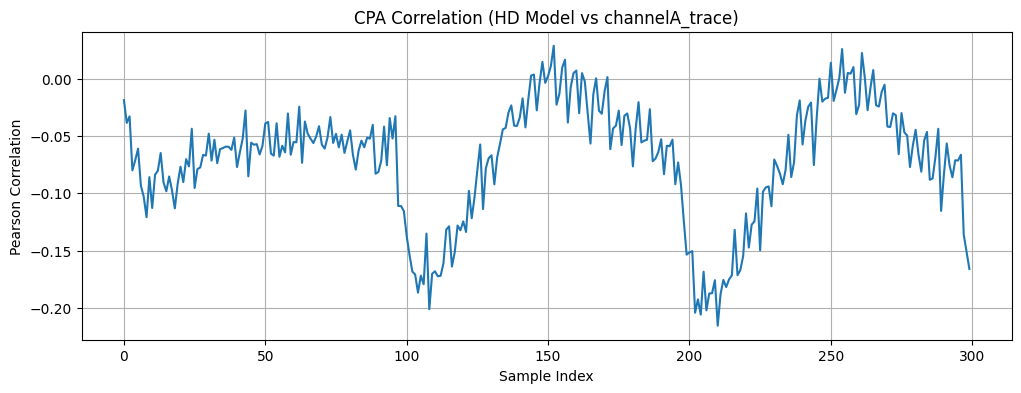

📍 Max correlation: -0.2155 at sample 210


In [43]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# HD labels
hd_values = [0, 8, 16, 24]

# 채널 A의 트레이스 (예: shape = (4, 40, ?))
# 목표 길이
target_length = 300

# Step 1: 트레이스 정규화 (자르기)
processed = []
for group in channelA_trace:
    trimmed_group = []
    for trace in group:
        if len(trace) >= target_length:
            trimmed_trace = trace[:target_length]
        else:
            continue  # 너무 짧은 트레이스는 무시
        trimmed_group.append(trimmed_trace)
    processed.append(trimmed_group)

# numpy array로 변환
processed = np.array(processed)
num_hd, num_valid, actual_len = processed.shape
print(f"✅ Shape after trimming: {processed.shape}")

# Step 2: reshape
traces = processed.reshape(-1, target_length)
labels = np.repeat(hd_values, num_valid)

# Step 3: CPA 분석
power_model = labels.astype(np.float64)
num_samples = traces.shape[1]
correlations = np.zeros(num_samples)

for i in range(num_samples):
    sample_column = traces[:, i]
    correlations[i], _ = pearsonr(sample_column, power_model)

# Step 4: 시각화
plt.figure(figsize=(12, 4))
plt.plot(correlations)
plt.title("CPA Correlation (HD Model vs channelA_trace)")
plt.xlabel("Sample Index")
plt.ylabel("Pearson Correlation")
plt.grid(True)
plt.show()

# Step 5: 최고 상관 위치 출력
max_idx = np.argmax(np.abs(correlations))
print(f"📍 Max correlation: {correlations[max_idx]:.4f} at sample {max_idx}")

: 

: 

: 